# 1-异常检测

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

sns.set(context="notebook", style="white")

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X, data.keys()

(array([[13.04681517, 14.74115241],
        [13.40852019, 13.7632696 ],
        [14.19591481, 15.85318113],
        [14.91470077, 16.17425987],
        [13.57669961, 14.04284944],
        [13.92240251, 13.40646894],
        [12.82213164, 14.22318782],
        [15.67636615, 15.89169137],
        [16.16287532, 16.20299807],
        [12.66645095, 14.89908374],
        [13.98454962, 12.95800822],
        [14.06146043, 14.54908874],
        [13.38988671, 15.56202142],
        [13.39350475, 15.62698794],
        [13.97900926, 13.28061494],
        [14.16791259, 14.46583829],
        [13.96176145, 14.75182421],
        [14.45899735, 15.07018563],
        [14.58476372, 15.82743424],
        [12.07427074, 13.0671109 ],
        [13.5491294 , 15.53827677],
        [13.98625042, 14.78776304],
        [14.96991942, 16.51830493],
        [14.25576597, 15.29427277],
        [15.33425   , 16.12469989],
        [15.6350487 , 16.49094477],
        [13.62081292, 15.45947525],
        [14.81548485, 15.339

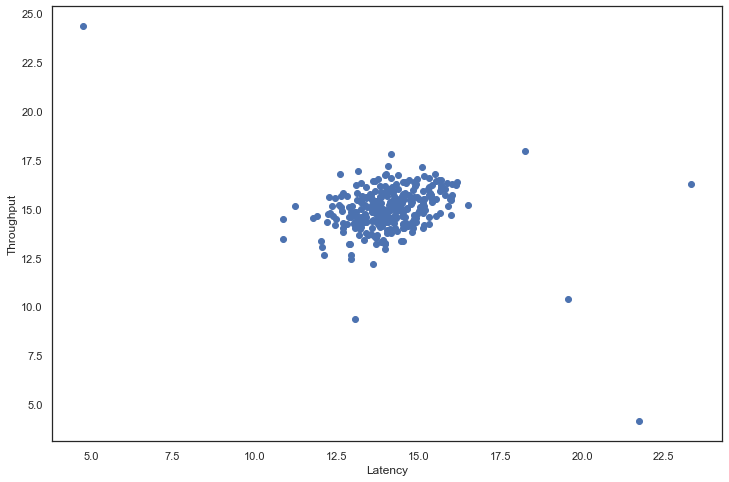

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[:,0], X[:,1])
plt.xlabel('Latency')
plt.ylabel('Throughput')
plt.show()

## estimate multivariate Gaussian parameters μ and $\sigma^2$

In [4]:
cov = np.cov(X.T)
cov

array([[ 1.83862041, -0.22786456],
       [-0.22786456,  1.71533273]])

In [5]:
def estimate_gaussian(X):
    mu = X.mean(axis = 0)
    sigma2 = np.sum(np.power(X-mu, 2), 0) / X.shape[0]

    return mu, sigma2

In [6]:
Xval = data['Xval']
yval = data['yval']

mu, sigma2 = estimate_gaussian(X)
mu, sigma2 

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

# 高斯独立分布模型
<img src="Gaussian_distribution.png">

In [7]:
def gaussian_distribution(X, mu, sigma2):
    p = (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-np.power((X - mu), 2) / (2*sigma2))
    return np.prod(p,axis = 1)   #横向连乘

scipy中的stats库提供了计算正态分布概率密度的函数

stats.multivariate_normal(mu,cov)训练了多元正态分布概率密度的模型

pdf()函数用于计算概率密度

stats.norm()训练的是独立正态分布模型

In [8]:
from scipy import stats
multi_normal = stats.multivariate_normal(mu, cov)
multi_normal.pdf(15)

0.07266054481836134

In [9]:
px = gaussian_distribution(X, mu, sigma2)
px.shape, px[:10]

((307,),
 array([0.06470829, 0.05030417, 0.07245035, 0.05031575, 0.06368497,
        0.04245832, 0.04790945, 0.03651115, 0.0186658 , 0.05068826]))

# 绘制轮廓线，进行可视化

In [10]:
def visualize_countors(mu, sigma2): #绘制高斯分布等高线
    #由X分布可知，选取5-25，范围比较合适
    X = np.linspace(5,25,100)
    y = np.linspace(5,25.100)

    xx,yy = np.meshgrid(X,y)
    X = np.c_[xx.flatten(), yy.flatten()]  #数据对应网格中每一个点
    z = gaussian_distribution(X, mu, sigma2).reshape(xx.shape)  #获取每一个点坐标的高斯值
    cont_levels = [10 ** h for h in range(-20, 0, 3)]  #当z为当前列表的值才绘出等高线（最高1） 不设置的话，会比较奇怪

    plt.contour(xx, yy, z, cont_levels)

<function matplotlib.pyplot.show(close=None, block=None)>

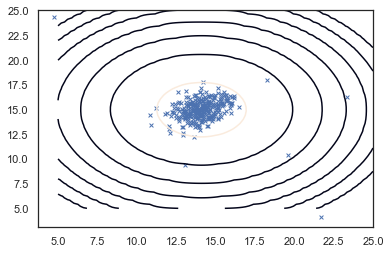

In [11]:
plt.figure()
visualize_countors(mu,sigma2)
plt.scatter(X[:,0],X[:,1], c='b',marker='x', s=15,linewidths=1)
plt.show

接下来，我们需要一个函数，找到给定概率密度值和真实标签的最佳阈值。 为了做到这一点，我们将为不同的epsilon值计算F1分数。
<img src="F1Score.png">

In [12]:
from sklearn.metrics import f1_score, classification_report

In [13]:
def select_threshold(X,pval, yval):

    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    pval = multi_normal.pdf(Xval)

    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)

    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype(int)
        fs.append(f1_score(yval, y_pred))
    
    argmax_fs = np.argmax(fs)

    return epsilon[argmax_fs], fs[argmax_fs]


In [14]:
e, fs = select_threshold(X,Xval, yval)
print('Best epsilon: {}\n Best F1_Score: {}'.format(e, fs))

Best epsilon: 3.6148577562381784e-05
 Best F1_Score: 0.8750000000000001


In [15]:
def select_threshold_1(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    
    for epsilon in np.linspace(np.min(pval),np.max(pval), num=1001):
        
        predictions = np.where(pval < epsilon, 1, 0)  #小于epsilon则预测为异常（为真）， 满足条件返回1，不满足返回0
        tp = np.sum(yval[np.where(predictions==1)]) #正确肯定，上面预测的为1，并且yval中也是1
        fp = np.sum(np.where(yval[np.where(predictions==1)]==0,1 ,0)) #错误肯定，预测为真，实际为假
        fn = np.sum(np.where(yval[np.where(predictions==0)]==1,1 ,0)) #错误否定

        if tp+fp ==0 or tp+fn == 0:
            continue

        precision = tp / (tp + fp)  #查准率
        recall = tp / (tp + fn)     #查全率
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [16]:
mu, sigma2 = estimate_gaussian(X)
px = gaussian_distribution(Xval, mu, sigma2)

epsilon, f1 = select_threshold_1(px, yval)
epsilon, f1

(8.990852779269492e-05, 0.8750000000000001)

最后，我们可以将阈值应用于数据集，并可视化结果。

## 根据阈值来判断异常

In [17]:
def detection(X,eps,mu,sigma2):
    px = gaussian_distribution(X,mu,sigma2)
    #进行判断异常点
    anomaly_points = X[np.where(px<eps)]
    return anomaly_points

In [18]:
def circle_anomaly_points(X):
    plt.scatter(X[:,0],X[:,1],s=80,facecolors='none',edgecolors='r')

In [19]:
outliers1 = np.where(multi_normal.pdf(Xval) < e)
outliers1

(array([300, 301, 302, 303, 304, 305, 306], dtype=int64),)

In [20]:
anomaly_points = detection(X,epsilon,mu,sigma2)
anomaly_points

array([[13.07931049,  9.34787812],
       [21.72713402,  4.12623222],
       [19.58257277, 10.411619  ],
       [23.33986753, 16.29887355],
       [18.26118844, 17.978309  ],
       [ 4.75261282, 24.35040725]])

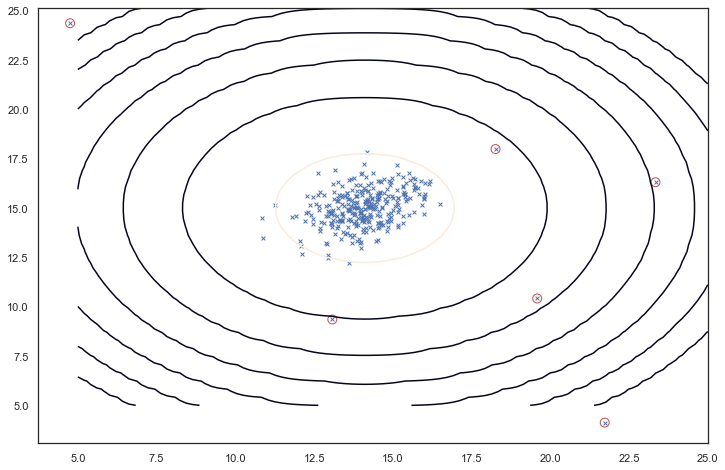

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
visualize_countors(mu,sigma2)
circle_anomaly_points(anomaly_points)
plt.scatter(X[:,0], X[:,1],c='b',marker='x',s=15,linewidths=1)
plt.show()

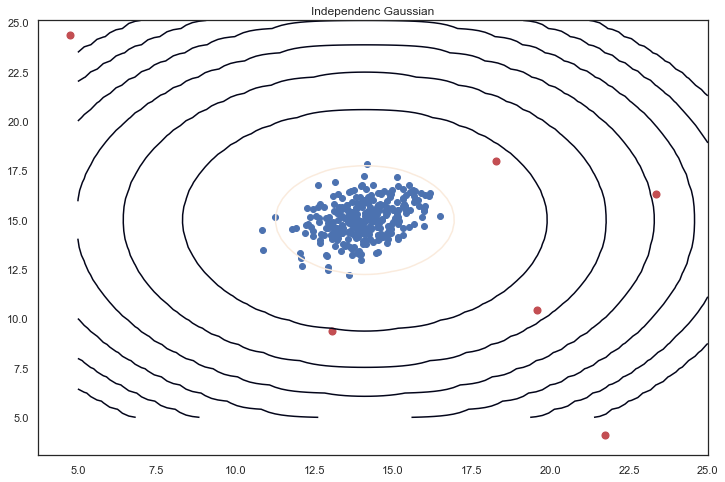

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[:,0], X[:,1])
visualize_countors(mu,sigma2)
ax.scatter(anomaly_points[:,0], anomaly_points[:, 1], s=50, color='r', marker='o')
plt.title("Independenc Gaussian")
plt.show()

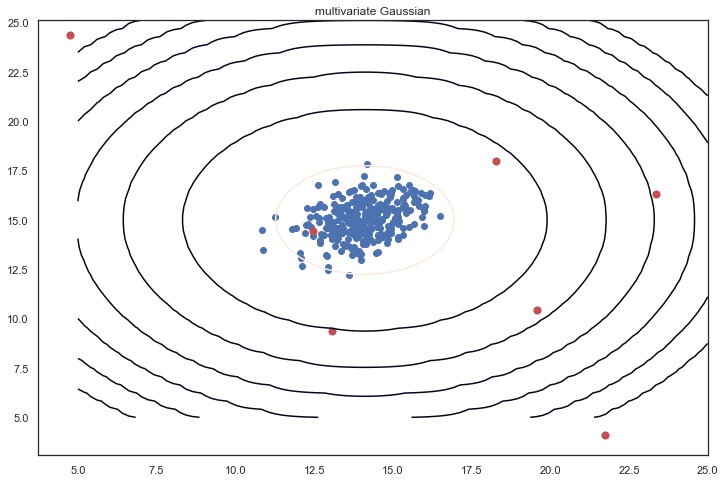

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
visualize_countors(mu,sigma2)
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers1,0], X[outliers1, 1], s=50, color='r', marker='o')
plt.title("multivariate Gaussian")
plt.show()

## high dimension data

In [ ]:
mat = loadmat('./data/ex8data2.mat')
mat.keys(),len(mat) 

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval']),
 6)

In [ ]:
X = mat.get('X')
X.shape

(1000, 11)

In [ ]:
Xval, yval = mat['Xval'], mat['yval']
Xval.shape, yval.shape

((100, 11), (100, 1))

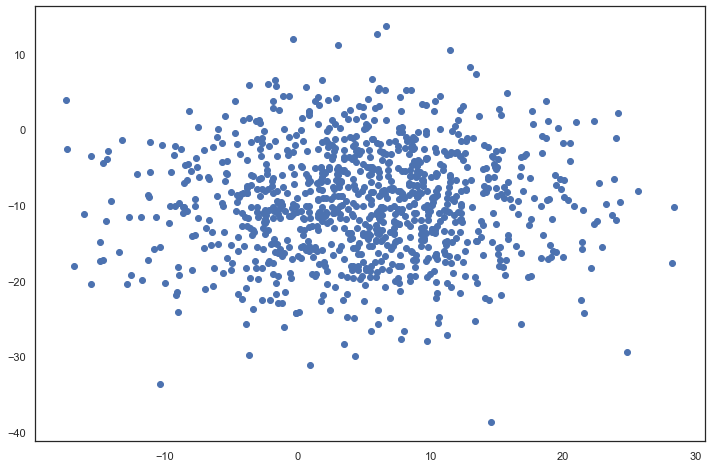

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
e, fs = select_threshold(X,Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 1.74667432759803e-19
Best F-score on validation data: 0.7368421052631577


In [ ]:
mu = X.mean(axis=0)
cov = np.cov(X.T)
multi_normal = stats.multivariate_normal(mu, cov)
pval = multi_normal.pdf(Xval)

y_pred = (pval <= e).astype(int)
print('find {} anamolies'.format(y_pred.sum()))

find 9 anamolies


In [ ]:
sigma = X.var(axis=0)

pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])
pval[:,2] = stats.norm(mu[2], sigma[2]).pdf(Xval[:,2])
pval[:,3] = stats.norm(mu[3], sigma[3]).pdf(Xval[:,3])
pval[:,4] = stats.norm(mu[4], sigma[4]).pdf(Xval[:,4])
pval[:,5] = stats.norm(mu[5], sigma[5]).pdf(Xval[:,5])
pval[:,6] = stats.norm(mu[6], sigma[6]).pdf(Xval[:,6])
pval[:,7] = stats.norm(mu[7], sigma[7]).pdf(Xval[:,7])
pval[:,8] = stats.norm(mu[8], sigma[8]).pdf(Xval[:,8])
pval[:,9] = stats.norm(mu[9], sigma[9]).pdf(Xval[:,9])
pval[:,10] = stats.norm(mu[10], sigma[10]).pdf(Xval[:,10])

pval.shape

(100, 11)

In [ ]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])
p[:,2] = stats.norm(mu[2], sigma[2]).pdf(X[:,2])
p[:,3] = stats.norm(mu[3], sigma[3]).pdf(X[:,3])
p[:,4] = stats.norm(mu[4], sigma[4]).pdf(X[:,4])
p[:,5] = stats.norm(mu[5], sigma[5]).pdf(X[:,5])
p[:,6] = stats.norm(mu[6], sigma[6]).pdf(X[:,6])
p[:,7] = stats.norm(mu[7], sigma[7]).pdf(X[:,7])
p[:,8] = stats.norm(mu[8], sigma[8]).pdf(X[:,8])
p[:,9] = stats.norm(mu[9], sigma[9]).pdf(X[:,9])
p[:,10] = stats.norm(mu[10], sigma[10]).pdf(X[:,10])

p.shape

(1000, 11)

In [ ]:
epsilon, f1 = select_threshold_1(pval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(epsilon, f1))

Best epsilon: 0.012420382026040781
Best F-score on validation data: 0.18749999999999997


C:\Users\Carlos\AppData\Local\Temp/ipykernel_11304/1599629962.py:15: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp / (tp + fp)


In [ ]:
preds = p < epsilon
len(preds)

1000